[![Open In colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DatosGeograficos/2_Joins_y_Viz/1_Visualizacion_solucion.ipynb)

<h1 id="tocheading">Tabla de contenidos</h1>
<div id="toc"></div>

In [2]:
# !pip install geopandas
# !apt install libspatialindex-dev
# !pip install rtree
# !pip install pysal
# !pip install contextily --> Para importar mapa base
# !pip install folium

In [1]:
import pandas as pd
import geopandas
import shapely
import pysal
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

# Geodatos y transporte

Sin lugar a dudas el entorno urbano es el lugar predilecto para los análisis con datos vectoriales y, además, el transporte es una de las fuentes de información más atractivas. No sólo por su riqueza como información en sí sino también por la relevancia del transporte en la vida cotidiana en las grandes ciudades, especialmente en América Latina donde el transporte suele ser un problema en sí mismo.

Es así que encontramos todo tipo de información en este rubro:

- Polígonos estáticos como barrios o jurisdicciones administrativas (educativas, por ej.) o censales (como radio o fracción censal en Argentina).

- Líneas o multilíneas estáticas como las rutas de los colectivos o el callejeros de la ciudad.

- Puntos estáticos como paradas de colectivos, estaciones de subtes y trenes.

- Puntos en tiempo real como la posición de colectivos, camiones de basura, cortes de tránsito, accidentes, etc.

## Cargamos datos

Vamos a leer la información. Noten que en todos los casos vamos a usar WGS 84.

In [3]:
def from_wkt(df, wkt_column, crs='EPSG:4326'):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(barrios, geometry='coordinates', crs=crs) # seteamos la columna de geometría
    
    return gdf

Es común que los archivos shapefile incluyan la información sobre el sistema de coordenadas empleado. Esta información se encuentra incluida en el archivo .prj

En esta notebook vamos a trabajar con las paradas y recorridos de colectivos, la información del censo 2010 (el último en Argentina al momento de escribir ésto) y las geometrías de los barrios.

Acá pueden ver los links de los archivos originales:

- https://data.buenosaires.gob.ar/dataset/colectivos-paradas
- https://data.buenosaires.gob.ar/dataset/colectivos-recorridos
- https://data.buenosaires.gob.ar/dataset/informacion-censal-por-radio/archivo/juqdkmgo-1214-resource

In [4]:
# !wget "https://datasets-humai.s3.amazonaws.com/datasets/recorrido-colectivos.zip"

In [5]:
folder = "recorrido-colectivos"
with zipfile.ZipFile(f"{folder}.zip", 'r') as f:
    f.extractall(folder)

In [6]:
recorridos = geopandas.read_file("recorrido-colectivos/recorrido-colectivos.shp")

In [7]:
recorridos.crs.name

'WGS 84'

In [8]:
# !wget 'https://datasets-humai.s3.amazonaws.com/datasets/paradas-de-colectivo.zip'

In [9]:
folder = "paradas-de-colectivo"
with zipfile.ZipFile(f"{folder}.zip", 'r') as f:
    f.extractall(folder)

In [10]:
paradas = geopandas.read_file("paradas-de-colectivo/paradas-de-colectivo.shp")

In [11]:
paradas.crs.name

'WGS 84'

In [12]:
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [13]:
barrios = from_wkt(barrios, "WKT")

In [14]:
barrios.crs.name

'WGS 84'

In [15]:
# !wget 'https://datasets-humai.s3.amazonaws.com/datasets/informacion-censal-por-radio-2010.zip'

In [16]:
folder = "informacion-censal-por-radio-2010"
with zipfile.ZipFile(f"{folder}.zip", 'r') as f:
    f.extractall(folder)

In [17]:
radios = geopandas.read_file("informacion-censal-por-radio-2010/informacion_censal_por_radio_2010.shp")

In [18]:
radios.crs.name

'WGS 84'

## Explorando polígonos

Un problema común suele ser tener una ruta o un callejero mucho más grande que el área que necesitamos analizar, por ejemplo, una ciudad, un barrio o una región delimitada arbitrariamente.

Para comenzar veamos las rutas de colectivos en el Área Metropolitana de Buenos Aires.

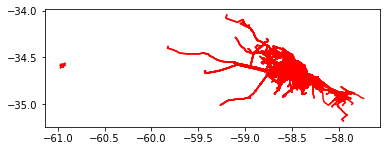

In [19]:
recorridos.plot(color="red")

Ok, eso no nos dice demasiado... Sí podemos ver que hay a la izquierda una serie de rutas que no está muy claro qué son... Filtrémoslas y volvamos a plotear. Para ello vamos a quedarnos con las rutas al este de la longitud -60.5.

### Ejercicio 
Filtrar los recorridos que están al oeste de la longiud -60.5. Tip: pueden tomar las coordenadas del centroide de las rutas. Guardar el resultado en recorridos_amba y graficar.

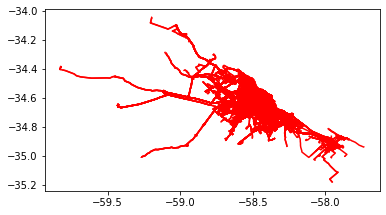

In [20]:
recorridos_amba = recorridos[recorridos.geometry.centroid.x > -60.5]
recorridos_amba.plot(color="red")

Bueno, ahora que filtramos se vé más prolijo pero, ¿qué estamos viendo realmente? Para entender un poco mejor qué estamos viendo sumemos la capa de barrios de capa y grafiquemos.

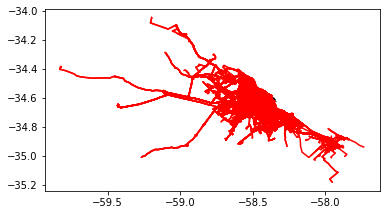

In [21]:
fig, ax = plt.subplots()
recorridos_amba.plot(ax=ax, color="red")
barrios.plot(ax=ax, color="black")
plt.show()

Mmm no podemos ver nada, ¿qué podemos hacer? El método plot incluye un parámetro alpha que regula la opacidad de la misma. Ajustando eso vamos a tener un mejor resultado. Además, vamos a agrandar la imagen para poder verla mejor.

In [22]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

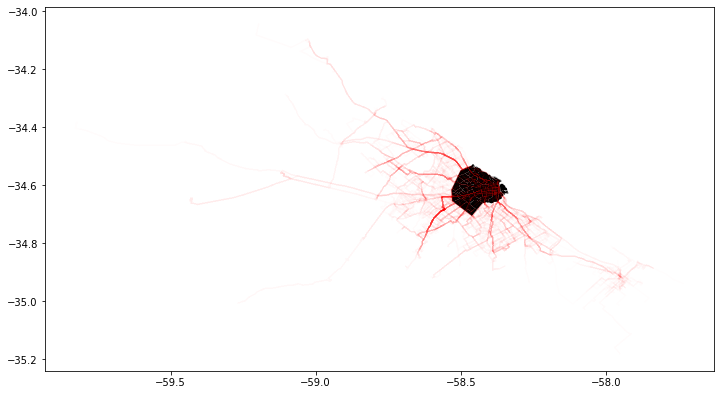

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
recorridos_amba.plot(ax=ax, color="red", alpha=0.008)
barrios.plot(ax=ax, color="black")
plt.show()

Ok, ahora sí podemos notar que las rutas exceden en mucho la ciudad de Buenos Aires. Para trabajar con esta información va a ser conveniente reducir el tamaño de las rutas sólo a la ciudad de Buenos Aires.

## Usando máscaras

Es común que en situaciones nos encontremos con que un polígono es demasiado grande para lo que necesitamos o que excede en tamaño a otro polígono. En estos casos vamos a tener que "cortar" un polígono para reducirlo al tamaño y forma necesarios.

Para poder usar los polígonos de CABA vamos a comenzar uniendo los barrios en un solo polígono (en vez de tener un polígono por barrio nos vamos a quedar con un solo polígono de todo CABA). Recordando la clase pasada, para hacer eso necesitamos agregar una columna constante, en este caso "ciudad" que sólo va a tener el valor "CABA" y luego aplicar **disolve**.

In [24]:
barrios["ciudad"] = "CABA"
mascara = barrios.dissolve(by="ciudad")

A continuación podemos "clipear" la capa de recorridos con la máscara.

In [25]:
recorridos_caba = geopandas.clip(recorridos, mascara)

/home/usuario/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Ahora sí, sólo veremos los recorridos dentro de CABA. Pero antes de hacer el gráfico vamos a incluir algunas mejoras. Por empezar vamos a ver paletas de color de CartoDB (una empresa que provee visualizaciones de mapas) en https://carto.com/carto-colors/ . En este caso vamos a querer sólo pintar los barrios y las calles, así que vamos a elegir una paleta cualitativa.
Elegimos la paleta **prism**. De allí tomamos, por ejemplo, el verde claro para marcar CABA y el gris oscuro para las calles.

In [26]:
# paleta: #5F4690,#1D6996,#38A6A5,#0F8554,#73AF48,#EDAD08,#E17C05,#CC503E,#94346E,#6F4070,#994E95,#666666

Además, vamos a agregar un mapa de fondo. Para ello vamos a usar la librería contextily, que nos provee acceso a una enorme variedad de proveedores de mapas.

In [27]:
import contextily as cx

En ctx.providers van a ver toda la lista:

In [28]:
cx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'attribution': '(C) Openstreetmap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by 

In [29]:
cx.providers.keys() # cada proveedor tiene a su vez distintos estilos

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])

In [30]:
cx.providers.Stamen.TonerBackground

{'url': 'https://stamen-tiles-{s}.a.ssl.fastly.net/{variant}/{z}/{x}/{y}{r}.{ext}',
 'attribution': 'Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors',
 'subdomains': 'abcd',
 'min_zoom': 0,
 'max_zoom': 20,
 'variant': 'toner-background',
 'ext': 'png',
 'name': 'Stamen.TonerBackground'}

Contextily hace muy sencillo incluir un mapa base con la función add_basemap, allí tenemos que establecer los axes a usar, la fuente del mapa (source) y la proyección. Contextily sólo funciona con las proyecciones WGS84 (EPSG:4326) y Spheric Mercator (EPSG: 3857). 
Spheric Mercator que es un sistema de coordenadas proyectadas (sobre un plano), usado en Google Maps. Se basa en el mismo datum y elipsoide que EPSG:4326(WGS84), pero proyectando las coordenadas en un plano (en vez de sobre el elispoide). Para ver más en detalles las diferencias dejamos los siguientes links:
- https://gis.stackexchange.com/questions/48949/epsg-3857-or-4326-for-googlemaps-openstreetmap-and-leaflet
- https://gis.stackexchange.com/questions/3334/difference-between-wgs84-and-epsg4326
- https://epsg.io/4326
- https://epsg.io/3857


Pueden consultar la documentación acá: https://contextily.readthedocs.io/en/latest/. 
Por default, la función supone que la proyección es Spheric Mercator, como estamos trabajando en WGS84 tenemos que setear el parámetro **crs** a 4326.

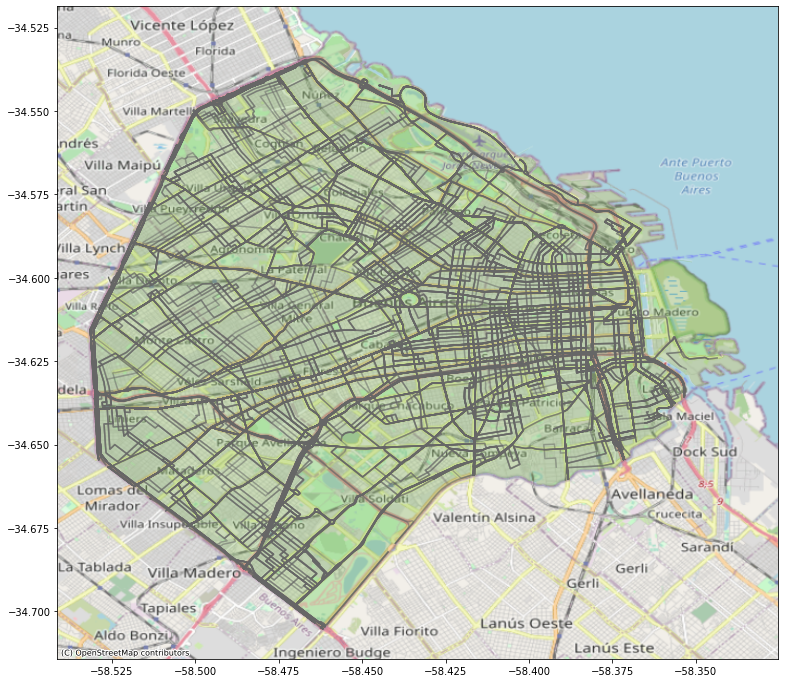

In [31]:
fig, ax = plt.subplots(figsize=(16, 12))
barrios.plot(ax=ax, color="#73AF48", alpha=0.3) # seteamos color y alpha
recorridos_caba.plot(ax=ax, color="#666666", alpha=0.5) # seteamos color y alpha
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

### Ejercicio

1- Explorar el DataFrame de paradas.

2- Filtrar las paradas en Mataderos, usando para ello una máscara.

3- Generar un mapa mostrando estas paradas y usando algún fondo de contextily, busquen un estilo que les guste :-)

In [32]:
mascara = barrios[barrios["BARRIO"] == "MATADEROS"]
paradas_mataderos = geopandas.clip(paradas, mascara)

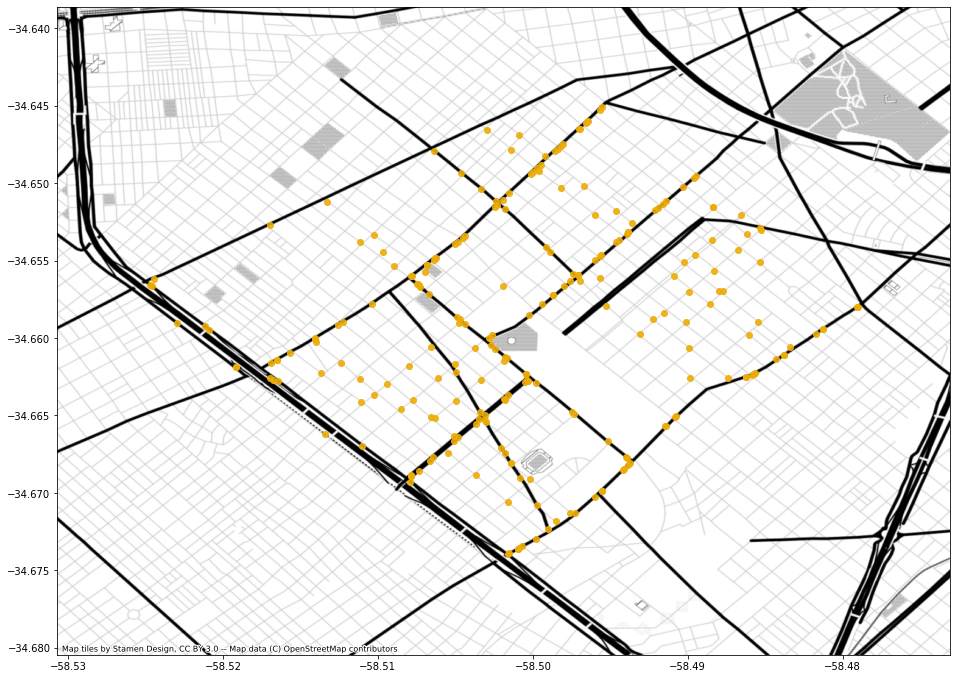

In [33]:
fig, ax = plt.subplots(figsize=(16, 12))
paradas_mataderos.plot(ax=ax, color="#EDAD08", alpha=0.9) # seteamos color y alpha
cx.add_basemap(ax, source=cx.providers.Stamen.TonerBackground, crs=4326)

## Coropletas

Por otra parte, nos gustaría agregar más información al mapa. Para eso vamos a usar la capa de radios censales, veamos qué información tiene.

In [34]:
radios.head()

RADIO_I       BARRIO COMUNA  POBLACI  VIVIEND  HOGARES  HOGARES_   AREA_KM  \
0    1_1_1       RETIRO      1    336.0     82.0     65.0      19.0  1.798997   
1   1_12_1  SAN NICOLAS      1    341.0    365.0    116.0      25.0  0.018565   
2  1_12_10  SAN NICOLAS      1    296.0    629.0    101.0       1.0  0.044380   
3  1_12_11  SAN NICOLAS      1    528.0    375.0    136.0       7.0  0.366340   
4   1_12_2  SAN NICOLAS      1    229.0    445.0    129.0      16.0  0.018363   

                                            geometry  
0  POLYGON ((-58.37189 -34.59199, -58.37202 -34.5...  
1  POLYGON ((-58.38593 -34.60444, -58.38575 -34.6...  
2  POLYGON ((-58.37879 -34.60528, -58.37741 -34.6...  
3  POLYGON ((-58.36733 -34.60562, -58.36713 -34.6...  
4  POLYGON ((-58.38454 -34.60436, -58.38311 -34.6...

Podemos ver que contamos con la población en el radio, la suma nos da el total de población de CABA (en 2010).

In [35]:
radios["POBLACI"].sum()

2890151.0

Vamos a pintar los radios por población, vamos a probar dos maneras:

1- Generar una mapa de color propio y pasárselo a la función. Esto es útil si queremos darle nuestro propio estilo al mapa y nos da mayor flexibilidad.

2- Usar los mapas de color predefinidos por matplotlib.

Por último, este tipo de gráficos se conoce como mapa de coropletas, porque agregan una capa de información basado en el color sobre las dimensiones geográficas. En este caso, vamos a pintar los radios censales según la cantidad de población.

Para crear nuestro propio **colormap** en matplotlib usamos LinearSegmentedColormap y pasamos una lista de colores. Esta lista es la paleta OrYel de CartoDB. Es lo que se conoce como una paleta secuencial, porque el tono va creciendo continuamente.

In [36]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    "mycmap",['#ee4d5a', '#f66356', '#f97b57', '#f7945d', '#f3ad6a', '#efc47e', '#ecda9a']
)

Para pasar el mapa de color usamos el parámetro **cmap**, **scheme** sirve para definir qué valor numérico de población mapear contra que valor de color y **k** es la cantidad de colores distintos a usar.

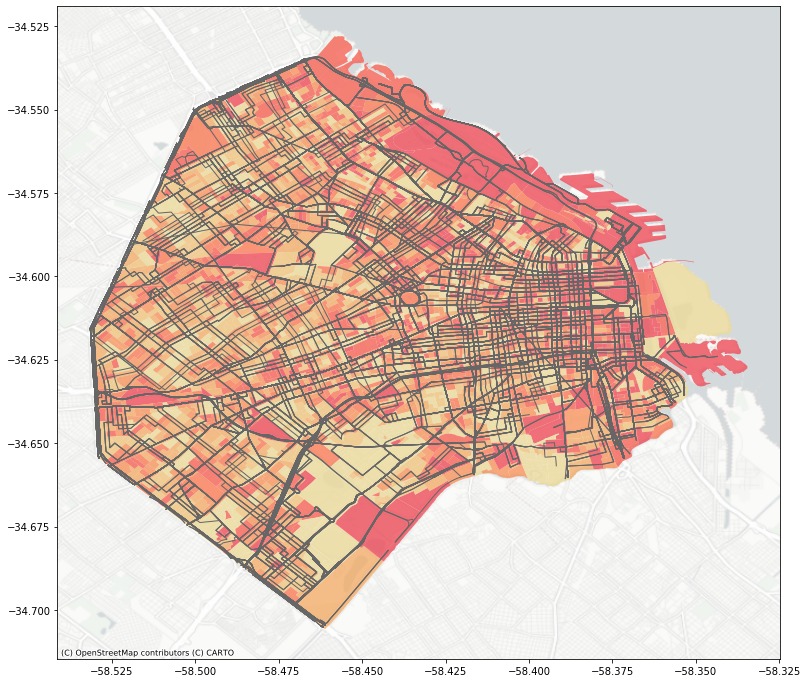

In [37]:
fig, ax = plt.subplots(figsize=(16, 12))
mapa = radios.plot(ax=ax, column="POBLACI", linewidth=0.03, cmap=cmap, scheme="quantiles", k=7, alpha=0.8)
recorridos_caba.plot(ax=ax, color="#666666", linewidth=1)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=4326)

Ahora veamos la segunda opción, que es por lo general la opción preferida. En esta referencia podrán encontrar las distintas paletas.
Vamos a elegir una opción divergente: RdYlBu. Para valores altos usa rojo, para valores bajos usa azul, y en los valores centrales coloca amarillo. 

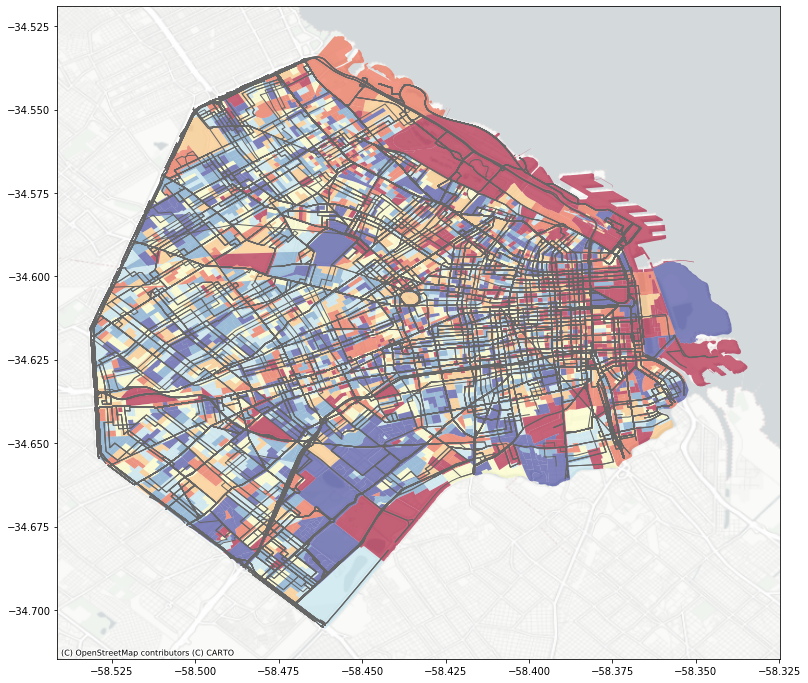

In [38]:
fig, ax = plt.subplots(figsize=(16, 12))
mapa = radios.plot(ax=ax, column="POBLACI", linewidth=0.03, cmap="RdYlBu", scheme="quantiles", k=7, alpha=0.6)
recorridos_caba.plot(ax=ax, color="#666666", linewidth=1)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=4326)

salida = "mapa_1.svg"
plt.savefig(salida, format='svg') # con este comando guardamos la imagen

## Mapas interactivos

Hasta el momento trabajamos con mapas estáticos, en ciertos ocasiones puede ser útil contar con un mapa interactivo. Para eso vamos a emplear la librería folium.

In [39]:
import folium

# Obelisco de Buenos Aires
lat, lon = -34.603668, -58.381345 

In [40]:
# En folium el crs default es EPSG:3857 vamos a usarlo porque encontramos problemas con 4326
m = folium.Map(location=(lat, lon), zoom_start=15) 
m

Folium permite usar distintos estilos de mapas. Algunos requieren de API key y otros no:

- OpenStreetMap
- Mapbox Bright (Niveles de zoom limitados para capa gratuita)
- Mapbox Control Room (Niveles de zoom limitados para capa gratuita)
- Stamen (Terrain, Toner, and Watercolor)
- Cloudmade (Must pass API key)
- Mapbox (Must pass API key)
- CartoDB (positron and dark_matter)

### Ejercicio

1- Prueben los parámetros zoom_start y tiles

In [41]:
folium.Map(location=(lat, lon), zoom_start=18)

In [42]:
folium.Map(location=(lat, lon), zoom_start=16, tiles='CARTODB positron')

### Agregando marcadores

Folium también nos permite agregar marcadores... Recordemos que las coordenadas originales son del Obelisco...

In [43]:
m = folium.Map(location=(lat, lon), zoom_start=16)

lat_colon, lon_colon = -34.600917, -58.382692 # agregamos las coordenadas del Colón

folium.Marker(
    [lat_colon, lon_colon],
    popup="Teatro Colon", # Problema al pasar tildes
    icon=folium.Icon(color='green')).add_to(m)

folium.Marker(
    [lat, lon],
    popup='Obelisco',
    icon=folium.Icon(color='red')).add_to(m)

In [44]:
m # Prueben hacer clic!

### Agregando capas a Folium

Ahora vamos a ver cómo agregar capas a folium desde GeoPandas. Para eso vamos a comenzar filtrando una línea de colectivos, luego exportamos el objeto a JSON (lo que se conoce como GeoJSON, ya que tiene las coordenadas de los vértices). Finalmente lo importamos desde folium y lo agregamos al mapa "m".

In [45]:
from folium.plugins import MarkerCluster

In [46]:
recorrido_132 = recorridos_caba.query("linea == '132'")

In [47]:
recorrido_132_json = recorrido_132.to_json()

In [48]:
folium.GeoJson(
    recorrido_132_json,
    name='recorrido'
).add_to(m)

In [49]:
m # prueben el zoom out

Para agregar estilo tenemos el parámetro **style_function**, el cual requiere que le pasemos una función, para lo cual empleamos una función **lambda**. Además, folium nos permite "prender" o "apagar" capas con LayerControl

In [50]:
estilo = {'fillColor': '#73AF48', 'color': '#73AF48'}

In [51]:
folium.GeoJson(
    barrios,
    name='barrios',
    style_function=lambda x: estilo
).add_to(m)

folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

In [52]:
m

### Clusters de marcadores

Folium también nos permite ver muchos marcadores en simultaneo y agruparlos o desagregarlos según el nivel de zoom. Para ello usamos MarkerCluster. Este objeto se instancia pasándole una lista de tuplas, donde para cada tupla el primer elemento es la latitud y el segundo elemento es la longitud. Además, podemos incluir como popup el nombre pasándole una lista de la misma extensión.

Vamos a mapear las paradas de la línea 132, para eso filtramos usando *.str*

In [53]:
paradas_132 = paradas[paradas["route_shor"].str.contains("132")] # filtro

puntos_paradas = list(zip(paradas_132.geometry.y, paradas_132.geometry.x)) # lista de tuplas

In [54]:
# Armamos un nuevo mapa
m = folium.Map(location=(lat, lon), zoom_start=16)

folium.GeoJson(
    recorrido_132_json,
    name='recorrido'
).add_to(m)

folium.GeoJson(
    barrios,
    name='barrios',
    style_function=lambda x: estilo
).add_to(m)

marker_cluster = MarkerCluster(puntos_paradas, popups = paradas_132["stop_name"].tolist(), name="paradas")

marker_cluster.add_to(m)

In [55]:
folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

In [56]:
m

### Ejercicio

Un tipo de visualización muy popular es el mapa de calor (heatmap en inglés), el cual representa en una escala de color divergente la distribución de valores (en este caso paradas de colectivos) en un mapa. Por lo general, se usa el color rojo para valores altos y el azul o celeste para valores bajos.

Vamos a graficar un HeatMap para lo cual deben:

1- Importar la clase HeatMap del módulo plugins de folium

2- Instanciar un mapa

3- Graficar un HeatMap de todas las paradas del AMBA, para lo cual les recomendamos leer a documentación (accesible desde Jupyter)


Prueben variar los parámetros **radius** , **max_zoom**, **max_val**

In [57]:
from folium.plugins import HeatMap
m = folium.Map(location=(lat, lon), zoom_start=16)

HeatMap(list(zip(paradas.geometry.y, paradas.geometry.x)), name="heatmap", radius=25, max_zoom=25, max_val=0.7).add_to(m)

In [58]:
m